In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

In [37]:
import pandas as pd

df = pd.read_csv("hour.csv")

print(df.shape)
print(df.columns)
print(df.head())


(17379, 17)
Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.2

In [38]:
from dataclasses import dataclass

@dataclass(frozen=True)
class PlotColors:
    true: str = "black"
    lds: str = "tab:blue"
    ar2: str = "tab:orange"
    arma21: str = "tab:green"

In [39]:
def plot1(lags, data, title, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # ACF
    plot_acf(
        data,
        lags=lags,
        ax=axes[0],
        alpha=0.05,      # confidence band alpha
        marker='o',
        markersize=3
    )
    axes[0].set_title(f"ACF {title}")
    axes[0].set_xlabel("Lag (hours)")
    axes[0].set_ylabel("Autocorrelation")

    # PACF
    plot_pacf(
        data,
        lags=lags,
        method='ywm',
        ax=axes[1],
        alpha=0.05,
        marker='o',
        markersize=3
    )
    axes[1].set_title(f"PACF {title}")
    axes[1].set_xlabel("Lag (hours)")
    axes[1].set_ylabel("Partial Autocorrelation")

    # Make points smaller + lighter
    for ax in axes:
        for line in ax.lines:
            line.set_markersize(3)   # smaller dots
            line.set_alpha(0.5)      # more transparent

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()

# plot1(200, train['cnt'], "train bike count", "test.jpg")

## Dataset split

In [40]:
split_index = int(len(df) * 0.8)

train = df.iloc[:split_index].copy()
test = df.iloc[split_index:].copy()

print("Train size:", len(train))
print("Test size:", len(test))
train.head(), test.head()

Train size: 13903
Test size: 3476


(   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
 0        1  2011-01-01       1   0     1   0        0        6           0   
 1        2  2011-01-01       1   0     1   1        0        6           0   
 2        3  2011-01-01       1   0     1   2        0        6           0   
 3        4  2011-01-01       1   0     1   3        0        6           0   
 4        5  2011-01-01       1   0     1   4        0        6           0   
 
    weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
 0           1  0.24  0.2879  0.81        0.0       3          13   16  
 1           1  0.22  0.2727  0.80        0.0       8          32   40  
 2           1  0.22  0.2727  0.80        0.0       5          27   32  
 3           1  0.24  0.2879  0.75        0.0       3          10   13  
 4           1  0.24  0.2879  0.75        0.0       0           1    1  ,
        instant      dteday  season  yr  mnth  hr  holiday  weekday  \
 13903    1390

massive spikes at lag 24, 48, 72, 96…

high amplitude, regular, sharp

periodic pattern dominated by the mean cycle

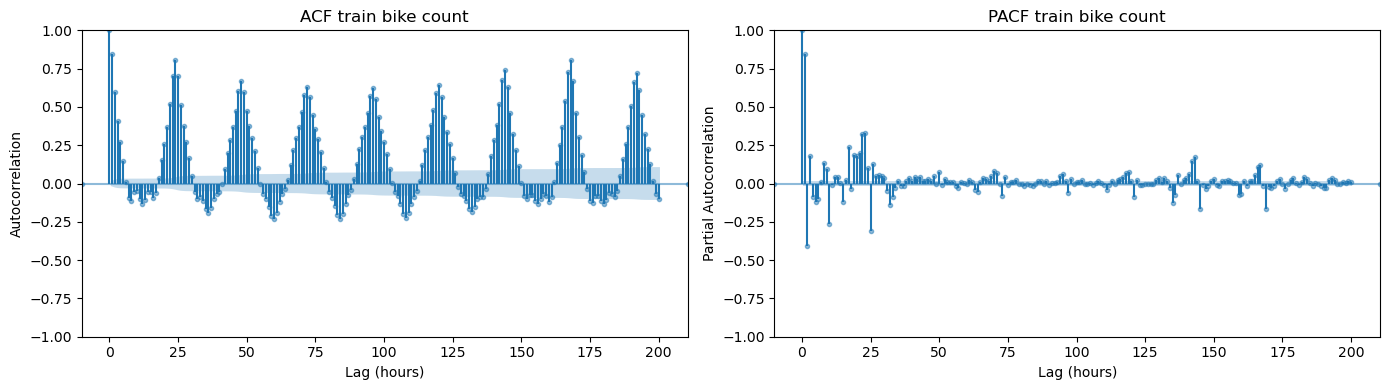

In [41]:
plot1(200, train['cnt'], "train bike count")

## Seasonality Removal 

The raw hourly bike demand shows strong daily seasonality, with consistent morning/evening peaks and nighttime lows.  
To remove this deterministic pattern, we subtract the long-run average demand for each hour of the day:

$$
r_t = x_t - \mu_{hr(t)}
$$

where

$$
\mu_h = \mathbb{E}[x_t \mid hr(t) = h].
$$

This deseasonalization removes the dominant hour-of-day effect while preserving meaningful short-term fluctuations.  
The resulting residual series is centered around zero and suitable for ARMA, LDS, and HMM modeling.

**Note: we will use only training set to compute the mean, and compute residual of test set with this train mean**

In [42]:
# 1. Compute hour-of-day mean on TRAIN only
hour_mean_train = train.groupby('hr')['cnt'].mean()

# 2. Assign train hour_mean
train['hour_mean'] = train['hr'].map(hour_mean_train)

# 3. Compute train residuals
train['residual'] = train['cnt'] - train['hour_mean']

# 4. Apply the SAME hour_mean mapping to TEST
# If an hour appears in test but not in train (unlikely), fill with global train mean
test['hour_mean'] = test['hr'].map(hour_mean_train)
test['hour_mean'] = test['hour_mean'].fillna(hour_mean_train.mean())

# 5. Compute test residuals
test['residual'] = test['cnt'] - test['hour_mean']


## Stationarity Check

An Augmented Dickey–Fuller test on the residual series yields:

- **ADF statistic:** −5.85  
- **p-value:** 3.61e-07

Both strongly reject the unit-root hypothesis, confirming stationarity.

The ACF of the residual shows no spike at lag 24, indicating that the daily seasonal component has been effectively removed while retaining realistic short-term dependence.

In [43]:
from statsmodels.tsa.stattools import adfuller

# check for training set
res = adfuller(train['residual'].dropna())

print("ADF Statistic:", res[0])
print("p-value:", res[1])
print("Used lags:", res[2])
print("Number of observations:", res[3])
print("Critical Values:", res[4])

ADF Statistic: -5.850056179878249
p-value: 3.606948587941335e-07
Used lags: 42
Number of observations: 13860
Critical Values: {'1%': -3.4308218983783987, '5%': -2.8617485574092236, '10%': -2.5668810102936184}


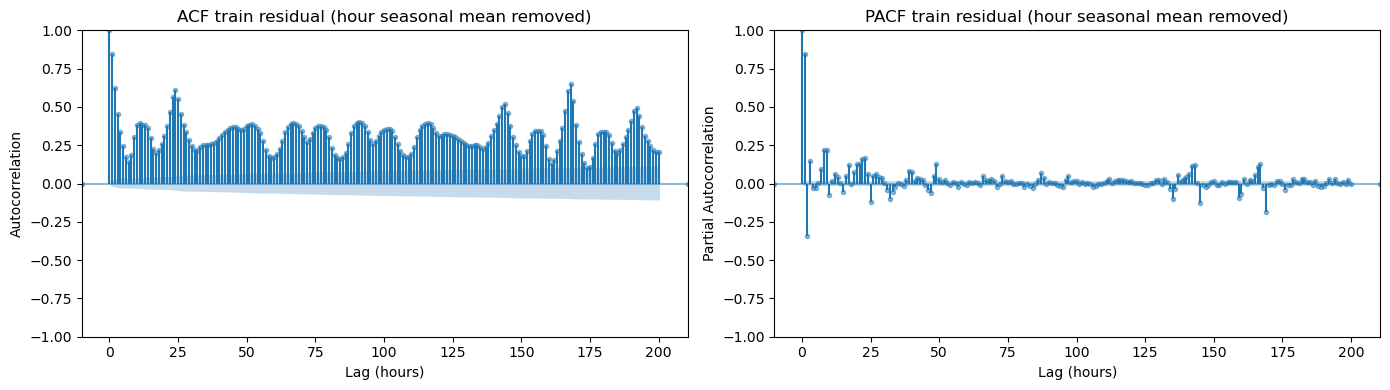

In [44]:
plot1(200, train['residual'], "train residual (hour seasonal mean removed)")

-------

## ARMA

### Determining ARMA(p, q) Orders from ACF and PACF

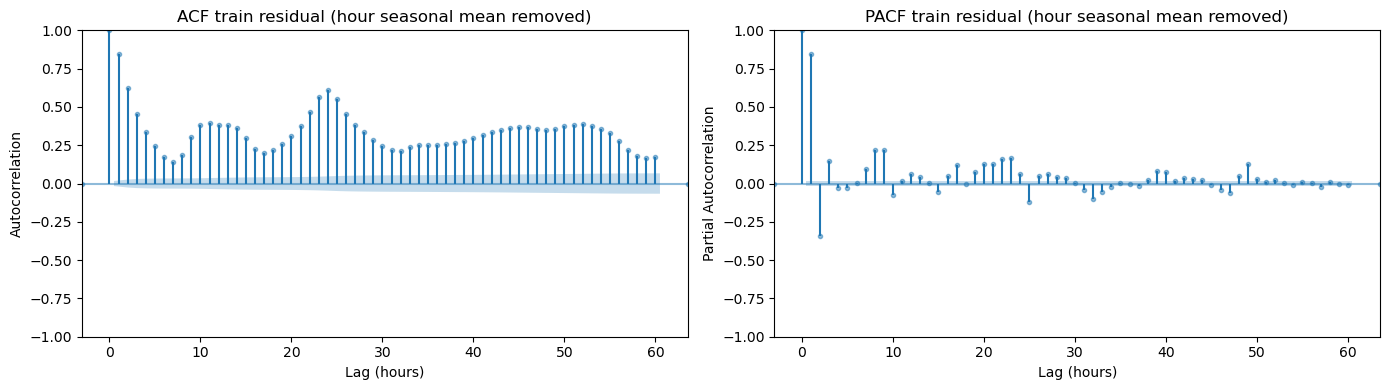

In [45]:
plot1(60, train['residual'], "train residual (hour seasonal mean removed)")

#### 1. PACF Analysis → Determines AR Order `p`
The PACF of the residual series shows:

- A **very strong spike at lag 1**
- Another **significant spike at lag 2**
- All remaining spikes are small and within the confidence band

**Interpretation:**

A sharp cutoff in PACF after lag `p` indicates an AR(p) model.

Since the PACF has large values at lags 1 and 2 and then drops off,
this strongly suggests: **AR(2)** structure

#### 2. ACF Analysis → Determines MA Order `q`

The ACF of the residual series:

- Decays slowly and smoothly
- Exhibits an oscillatory pattern
- Does **not** show a sharp cutoff at any specific lag

**Interpretation:**

A slow decay in the ACF indicates AR behavior, while a sharp cutoff would
suggest MA(q). Because no cutoff is observed, the ACF does **not** strongly support
a pure MA model. However, the slow decay suggests that including a small MA term
may improve the fit. But your PACF also shows a significant spike at lag 1 and some weak remaining structure.
This indicates short-memory shock noise that is not fully explained by the AR terms. These disturbances correspond to random components not captured by deterministic seasonality or AR structure.

shock: A sudden, unexpected change that is not explained by the usual pattern.

attempts: **ARMA(2, 0)**, **ARMA(2, 1)**

### ARMA fit

In [46]:
# Fit AR(2) model (ARIMA with q=0, d=0)
model_ar2 = ARIMA(train['residual'], order=(2, 0, 0)).fit()

print(model_ar2.summary())
print("AIC:", model_ar2.aic)

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                13903
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -76357.274
Date:                Tue, 13 Jan 2026   AIC                         152722.548
Time:                        15:31:25   BIC                         152752.707
Sample:                             0   HQIC                        152732.591
                              - 13903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.155e-07      2.530  -8.52e-08      1.000      -4.959       4.959
ar.L1          1.1406      0.006    199.674      0.000       1.129       1.152
ar.L2         -0.3456      0.007    -48.809      0.0

In [47]:
# Fit ARMA(2,1)
model_arma21 = ARIMA(train['residual'], order=(2, 0, 1)).fit()

print(model_arma21.summary())
print("AIC:", model_arma21.aic)

                               SARIMAX Results                                
Dep. Variable:               residual   No. Observations:                13903
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -76213.950
Date:                Tue, 13 Jan 2026   AIC                         152437.900
Time:                        15:31:25   BIC                         152475.600
Sample:                             0   HQIC                        152450.455
                              - 13903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.363e-06      2.756  -1.95e-06      1.000      -5.401       5.401
ar.L1          0.8404      0.021     40.289      0.000       0.800       0.881
ar.L2         -0.0925      0.020     -4.583      0.0

In [48]:
print("AIC AR(2):", model_ar2.aic)
print("AIC ARMA(2,1):", model_arma21.aic)

AIC AR(2): 152722.54762628596
AIC ARMA(2,1): 152437.9003493922


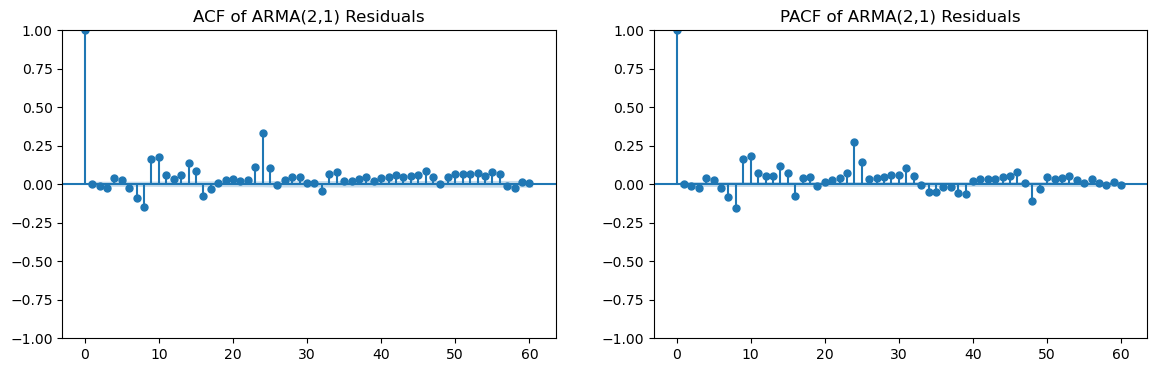

In [49]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
plot_acf(model_arma21.resid, lags=60, ax=ax[0])
plot_pacf(model_arma21.resid, lags=60, ax=ax[1])
ax[0].set_title("ACF of ARMA(2,1) Residuals")
ax[1].set_title("PACF of ARMA(2,1) Residuals")
plt.show()

A lower AIC indicates a better balance between model fit and complexity.
Since **ARMA(2,1) achieves a substantially lower AIC**, it is the preferred model statistically.

The ACF and PACF plots of the ARMA(2,1) residuals show:

- All autocorrelation values lie very close to zero.
- No significant spikes remain outside the confidence intervals.
- There is no systematic pattern or remaining cyclical structure.
- PACF similarly shows no meaningful remaining partial correlations.

This indicates that:

1. The ARMA(2,1) model has successfully captured the serial dependence in the data.
2. The residuals behave like white noise—an essential requirement for a well-specified ARMA model.
---

### ARMA Prediction

In [50]:
def rolling_arma21(train, test, const, phi1, phi2, theta1):
    """
    True rolling 1-step-ahead ARMA(2,1) forecasting.
    No refitting. Extremely fast.
    """
    y = list(train.values)
    preds = []
    # initialize errors (set last error to 0)
    last_err = 0  

    # initial in-sample forecast for y[-1] to get last_err
    y_hat_prev = const + phi1*y[-1] + phi2*y[-2]
    last_err = y[-1] - y_hat_prev

    for t in range(len(test)):
        y_tm1 = y[-1]
        y_tm2 = y[-2]

        # 1-step forecast
        y_hat = const + phi1*y_tm1 + phi2*y_tm2 + theta1*last_err
        
        preds.append(y_hat)

        # update error using the TRUE future value
        true_y = test.iloc[t]
        last_err = true_y - y_hat

        # update the series
        y.append(true_y)

    return np.array(preds)

# --- Rolling forecasts for residual ---
resid_train = train['residual']
resid_test  = test['residual']

pred_resid_arma21_roll = rolling_arma21(
    train = resid_train,
    test = resid_test,
    const = model_arma21.params['const'],
    phi1 = model_arma21.params['ar.L1'],
    phi2 = model_arma21.params['ar.L2'],
    theta1 = model_arma21.params['ma.L1']
)

pred_resid_ar2_roll = rolling_arma21(
    train = resid_train,
    test = resid_test,
    const = model_ar2.params['const'],
    phi1 = model_ar2.params['ar.L1'],
    phi2 = model_ar2.params['ar.L2'],
    theta1 = 0 # MA(0) in this case
)

After fitting the ARMA(2,1) model on the training residuals, we obtain the
parameters:

- `const` = $c$
- `ar.L1` = $\phi_1$
- `ar.L2` = $\phi_2$
- `ma.L1` = $\theta_1$

The ARMA(2,1) model is:

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t + \theta_1 \epsilon_{t-1},
$$

where $\epsilon_t$ is white noise.

For one-step-ahead prediction, the noise has mean zero, so the conditional mean
is:

$$
\hat{y}_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \theta_1 \epsilon_{t-1},
$$

with

$$
\epsilon_{t-1} = y_{t-1} - \hat{y}_{t-1}.
$$

Then we do this simple recursive forecasting procedure.

In [51]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

### Analysis on predicted residual

In [52]:
# Evaluate on residual
mae_ar2_r,  rmse_ar2_r  = evaluate(resid_test, pred_resid_ar2_roll)
mae_a21_r,  rmse_a21_r  = evaluate(resid_test, pred_resid_arma21_roll)

print("ROLLING AR(2) residual     - MAE:", mae_ar2_r,  "RMSE:", rmse_ar2_r)
print("ROLLING ARMA(2,1) residual - MAE:", mae_a21_r, "RMSE:", rmse_a21_r)

ROLLING AR(2) residual     - MAE: 53.58339275447054 RMSE: 82.84345722263048
ROLLING ARMA(2,1) residual - MAE: 53.07220730959808 RMSE: 81.79842403587764


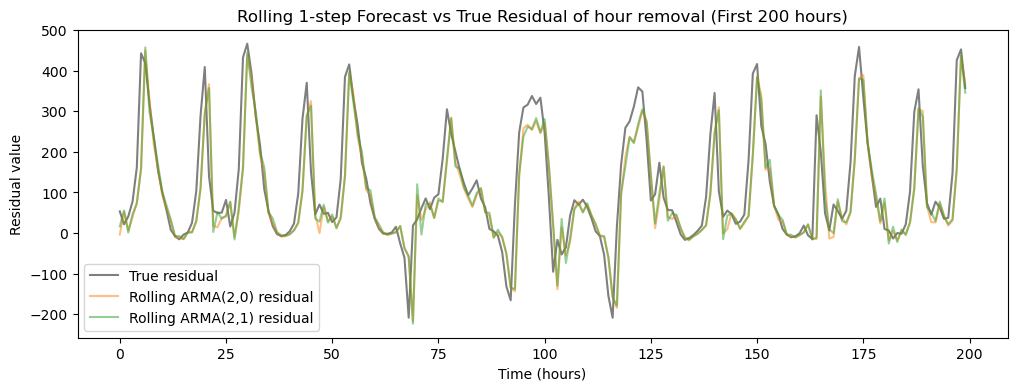

In [53]:
plt.figure(figsize=(12,4))
plt.plot(resid_test.values[:200], label='True residual', alpha=0.5, color = PlotColors.true)
plt.plot(pred_resid_ar2_roll[:200], label='Rolling ARMA(2,0) residual', alpha=0.5, color = PlotColors.ar2)
plt.plot(pred_resid_arma21_roll[:200], label='Rolling ARMA(2,1) residual', alpha=0.5, color = PlotColors.arma21)
plt.title("Rolling 1-step Forecast vs True Residual of hour removal (First 200 hours)")
plt.xlabel("Time (hours)")
plt.ylabel("Residual value")
plt.legend()
plt.show()


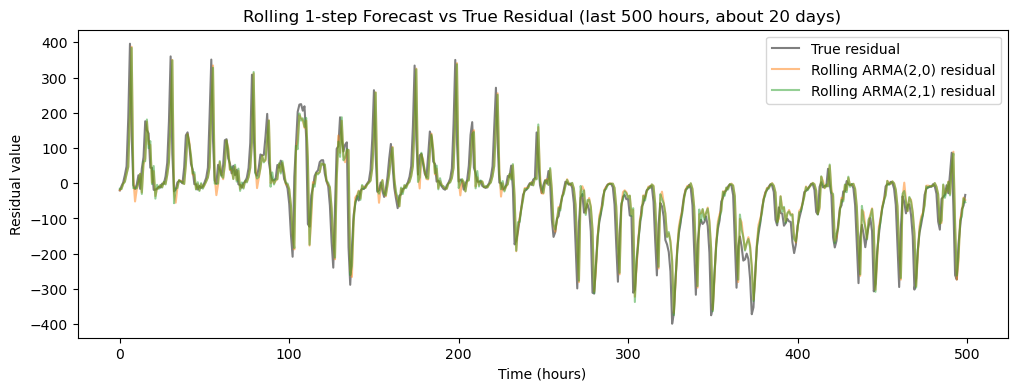

In [54]:
plt.figure(figsize=(12,4))
plt.plot(resid_test.values[-500:], label='True residual', alpha=0.5, color = PlotColors.true)
plt.plot(pred_resid_ar2_roll[-500:], label='Rolling ARMA(2,0) residual', alpha=0.5, color = PlotColors.ar2)
plt.plot(pred_resid_arma21_roll[-500:], label='Rolling ARMA(2,1) residual', alpha=0.5, color = PlotColors.arma21)
plt.title("Rolling 1-step Forecast vs True Residual (last 500 hours, about 20 days)")
plt.xlabel("Time (hours)")
plt.ylabel("Residual value")
plt.legend()
plt.show()

### Analysis on predicted final bike count

In [55]:
# Reconstruct counts using the same hour_mean as before
test['pred_ar2_roll']    = pred_resid_ar2_roll    + test['hour_mean'].values
test['pred_arma21_roll'] = pred_resid_arma21_roll + test['hour_mean'].values

mae_ar2_c,  rmse_ar2_c  = evaluate(test['cnt'], test['pred_ar2_roll'])
mae_a21_c,  rmse_a21_c  = evaluate(test['cnt'], test['pred_arma21_roll'])

print("ROLLING AR(2) reconstructed     - MAE:", mae_ar2_c,  "RMSE:", rmse_ar2_c)
print("ROLLING ARMA(2,1) reconstructed - MAE:", mae_a21_c, "RMSE:", rmse_a21_c)

ROLLING AR(2) reconstructed     - MAE: 53.58339275447054 RMSE: 82.84345722263048
ROLLING ARMA(2,1) reconstructed - MAE: 53.07220730959808 RMSE: 81.79842403587764


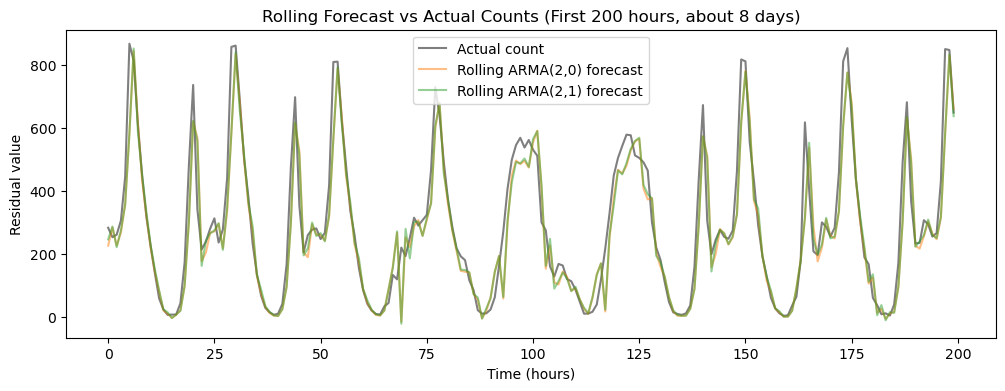

In [56]:
plt.figure(figsize=(12,4))
plt.plot(test['cnt'].values[:200], label='Actual count', alpha=0.5, color = PlotColors.true)
plt.plot(test['pred_ar2_roll'].values[:200], label='Rolling ARMA(2,0) forecast', alpha=0.5, color = PlotColors.ar2)
plt.plot(test['pred_arma21_roll'].values[:200], label='Rolling ARMA(2,1) forecast', alpha=0.5, color = PlotColors.arma21)
plt.title("Rolling Forecast vs Actual Counts (First 200 hours, about 8 days)")
plt.xlabel("Time (hours)")
plt.ylabel("Residual value")
plt.legend()
plt.show()

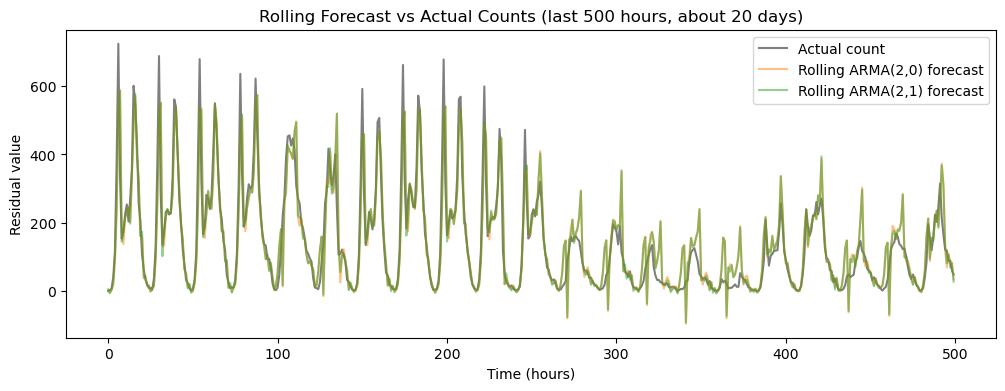

In [57]:
plt.figure(figsize=(12,4))
plt.plot(test['cnt'].values[-500:], label='Actual count', alpha=0.5, color = PlotColors.true)
plt.plot(test['pred_ar2_roll'].values[-500:], label='Rolling ARMA(2,0) forecast', alpha=0.5, color = PlotColors.ar2)
plt.plot(test['pred_arma21_roll'].values[-500:], label='Rolling ARMA(2,1) forecast', alpha=0.5, color = PlotColors.arma21)
plt.title("Rolling Forecast vs Actual Counts (last 500 hours, about 20 days)")
plt.xlabel("Time (hours)")
plt.ylabel("Residual value")
plt.legend()
plt.show()

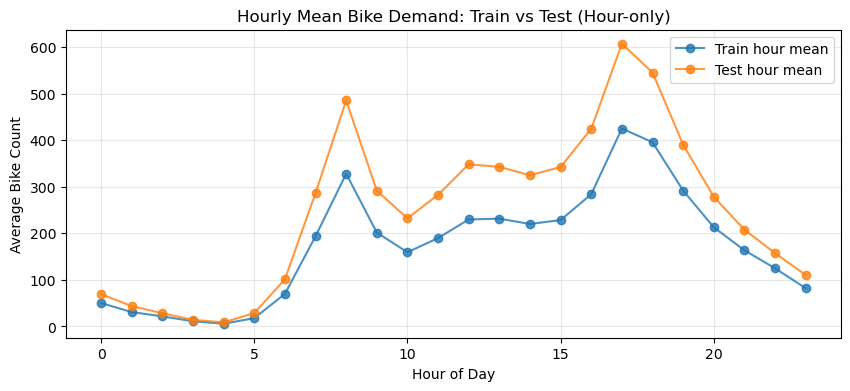

In [58]:
# Hour-only seasonal mean
hour_mean_train = train.groupby("hr")["cnt"].mean()
hour_mean_test  = test.groupby("hr")["cnt"].mean()

hour_diff = hour_mean_test - hour_mean_train

plt.figure(figsize=(10,4))

plt.plot(
    hour_mean_train.index,
    hour_mean_train.values,
    label="Train hour mean",
    marker="o",
    alpha=0.8
)

plt.plot(
    hour_mean_test.index,
    hour_mean_test.values,
    label="Test hour mean",
    marker="o",
    alpha=0.8
)

plt.xlabel("Hour of Day")
plt.ylabel("Average Bike Count")
plt.title("Hourly Mean Bike Demand: Train vs Test (Hour-only)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


-------

# LDS

In [59]:
from pykalman import KalmanFilter

## model fitting

In [60]:
y_train = train['residual'].values
y_test  = test['residual'].values
# Define 1D LDS model (latent dim = 1, obs dim = 1)
kf = KalmanFilter(
    transition_matrices = np.array([[1]]),     # A
    observation_matrices = np.array([[1]]),    # C
)

# Fit parameters using EM on training set
kf = kf.em(y_train, n_iter=50)

# Kalman filtering on training
filtered_state_means, filtered_state_covariances = kf.filter(y_train)


## predict

In [61]:
pred_resid_lds = []

# Start from last filtered state
state_mean = filtered_state_means[-1]
state_cov  = filtered_state_covariances[-1]

A = kf.transition_matrices
C = kf.observation_matrices
Q = kf.transition_covariance
R = kf.observation_covariance

for t in range(len(y_test)):
    # Predict next latent state
    state_mean = A @ state_mean
    state_cov  = A @ state_cov @ A.T + Q
    
    # Predict residual
    y_hat = C @ state_mean
    pred_resid_lds.append(y_hat[0])
    
    # Then update with true test residual
    # (rolling 1-step-ahead Kalman filter)
    state_mean, state_cov = kf.filter_update(
        state_mean,
        state_cov,
        observation = y_test[t]
    )

pred_resid_lds = np.array(pred_resid_lds)

## evalution

In [62]:
mae_lds, rmse_lds = evaluate(y_test, pred_resid_lds)

print("LDS residual MAE:", mae_lds)
print("LDS residual RMSE:", rmse_lds)

LDS residual MAE: 61.74198257007104
LDS residual RMSE: 92.75493333585239


### bike count prediction

In [63]:
test['pred_lds'] = pred_resid_lds + test['hour_mean']
mae_lds_c, rmse_lds_c = evaluate(test['cnt'], test['pred_lds'])

print("LDS reconstructed MAE:", mae_lds_c)
print("LDS reconstructed RMSE:", rmse_lds_c)

LDS reconstructed MAE: 61.74198257007104
LDS reconstructed RMSE: 92.75493333585239


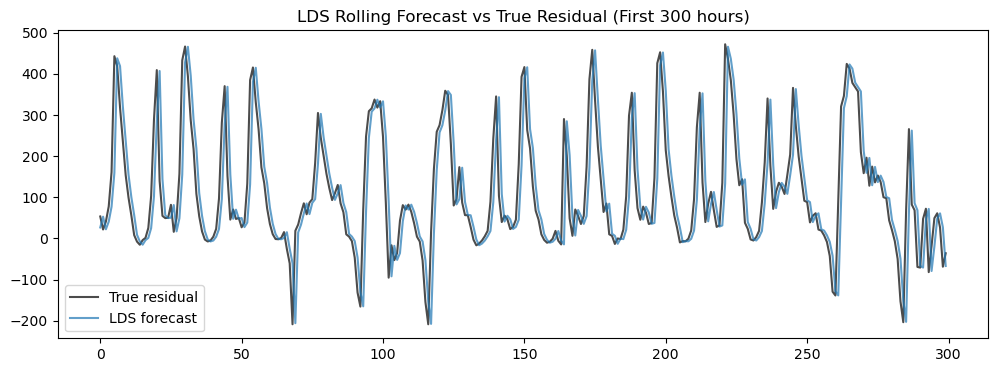

In [64]:
plt.figure(figsize=(12,4))
plt.plot(y_test[:300], label='True residual', alpha=0.7, color = PlotColors.true)
plt.plot(pred_resid_lds[:300], label='LDS forecast', alpha=0.7, color = PlotColors.lds)
plt.title("LDS Rolling Forecast vs True Residual (First 300 hours)")
plt.legend()
plt.show()

# Overall comparison

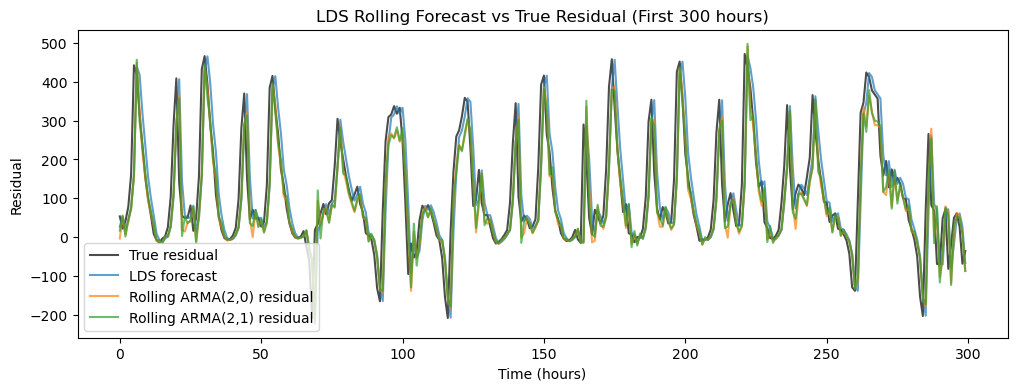

In [66]:
plt.figure(figsize=(12,4))
plt.plot(y_test[:300], label='True residual', alpha=0.7, color = PlotColors.true)
plt.plot(pred_resid_lds[:300], label='LDS forecast', alpha=0.7, color = PlotColors.lds)
plt.plot(pred_resid_ar2_roll[:300], label='Rolling ARMA(2,0) residual', alpha=0.7, color = PlotColors.ar2)
plt.plot(pred_resid_arma21_roll[:300], label='Rolling ARMA(2,1) residual', alpha=0.7, color = PlotColors.arma21)
plt.title("LDS Rolling Forecast vs True Residual (First 300 hours)")
plt.legend()
plt.xlabel("Time (hours)")
plt.ylabel("Residual")
plt.show()

- ROLLING AR(2)  
    - MAE: 53.583 RMSE: 82.843 
- ROLLING ARMA(2,1)  
    - MAE: 53.072 RMSE: 81.798 
- LDS  
    - MAE: 61.742 RMSE: 92.755